In [9]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import numpy.random as npr
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline
plt.style.use('bmh')

In [10]:
#!pip install tensorflow
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow import keras

In [11]:
# Loading Data
data_train = np.load('data_train.npy')
labels_train = np.load('labels_train.npy')

labels_names =['Stadium','Building','Traffic Sign','Forest','Flowers',
              'Street','Classroom','Bridge','Statue','Lake']

print(data_train.shape, labels_train.shape)

(270000, 3124) (3124,)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(data_train.transpose(), labels_train, test_size=0.20)


In [13]:
X_train, X_test, y_train, y_test
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
X_train = np.resize(X_train,(2499,300,300,3))
X_test = np.resize(X_test,(625,300,300,3))
y_train_new = y_train - 1
y_test_new = y_test - 1
print(y_train_new)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_new))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test_new))

(2499, 270000)
(625, 270000)
(2499,)
(625,)
[7. 9. 5. ... 0. 5. 3.]


2021-12-05 14:50:08.839565: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/dlisiansky/.local/lib/python3.8/site-packages/cv2/../../lib64:
2021-12-05 14:50:08.839632: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-05 14:50:08.839679: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c0712a-s17.ufhpc): /proc/driver/nvidia/version does not exist
2021-12-05 14:50:08.840156: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [15]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [16]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(300,
                                  300,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

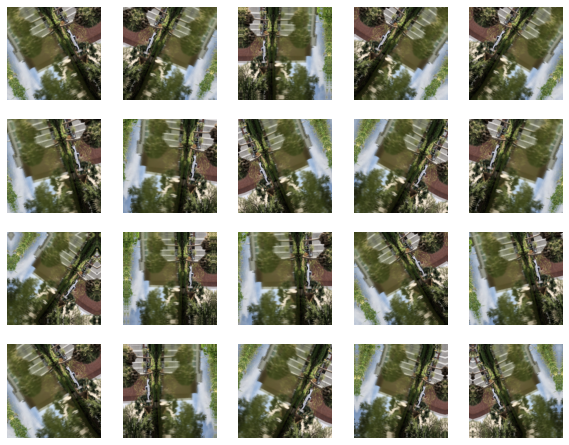

In [17]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(20):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [24]:
num_classes = 10

model_aug = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  #layers.Dropout(0.25),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  #layers.Dropout(0.25),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  #layers.Dropout(0.25),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  #layers.Dropout(0.25),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(512, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(1024, activation='relu'),
  layers.Dense(num_classes)
])



In [28]:
model_aug.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

checkpoint_filepath = 'model_1024.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [34]:
epochs=20
history = model_aug.fit(
  train_dataset,
  validation_data=test_dataset,
  epochs=epochs,
  callbacks = [model_checkpoint_callback]
)

Epoch 1/20
40/40 [==============================] - 79s 2s/step - loss: 0.7185 - accuracy: 0.7431 - val_loss: 0.8997 - val_accuracy: 0.7072
Epoch 2/20
40/40 [==============================] - 79s 2s/step - loss: 0.6066 - accuracy: 0.7823 - val_loss: 0.9091 - val_accuracy: 0.7184
Epoch 3/20
40/40 [==============================] - 78s 2s/step - loss: 0.5848 - accuracy: 0.8051 - val_loss: 0.9251 - val_accuracy: 0.7088
Epoch 4/20
40/40 [==============================] - 79s 2s/step - loss: 0.5308 - accuracy: 0.8147 - val_loss: 1.2439 - val_accuracy: 0.6672
Epoch 5/20
40/40 [==============================] - 79s 2s/step - loss: 0.5468 - accuracy: 0.8087 - val_loss: 0.9633 - val_accuracy: 0.7136
Epoch 6/20
40/40 [==============================] - 79s 2s/step - loss: 0.4965 - accuracy: 0.8443 - val_loss: 0.9361 - val_accuracy: 0.7344
Epoch 7/20
40/40 [==============================] - 79s 2s/step - loss: 0.4877 - accuracy: 0.8239 - val_loss: 1.0447 - val_accuracy: 0.7024
Epoch 8/20
40/40 [==

In [35]:
# this gives the prediction confidence
model_new = tf.keras.models.load_model('model_1024.h5')
predictions = model_new.predict(X_test)


In [36]:
scores_cnn = tf.nn.softmax(predictions)

In [37]:
scores_cnn_np = np.array(scores_cnn)

In [38]:
final_scores = scores_cnn_np
num_pred = final_scores.shape[0]
final_predictions = np.zeros(num_pred)
#final_scores.shape
for i in range(num_pred):
    index = np.where(final_scores[i,:] == np.amax(final_scores[i,:]))
    #print(index)
    final_predictions[i] = index[0] + 1
    
#final_predictions

conf_matrix_boost = confusion_matrix(y_test, final_predictions)
class_report_boost = classification_report(y_test, final_predictions)
print(conf_matrix_boost)
print(class_report_boost)

[[46  4  0  0  1  0  3  4  1  1]
 [ 2 38  1  2  0  3  3  2  8  0]
 [ 0  5 47  0  4  4  3  8  2  0]
 [ 0  3  0 62  0  1  0  0  0  1]
 [ 0  0  1  0 49  0  0  1  1  0]
 [ 1  0  0  0  0 56  1  4  6  4]
 [ 0  0  2  0  0  1 59  3  3  0]
 [ 2  5  1  7  0  3  0 41  4  5]
 [ 0  3  4  0  0  2  2  5 35  0]
 [ 1  2  1  1  0  1  0  1  2 46]]
              precision    recall  f1-score   support

         1.0       0.88      0.77      0.82        60
         2.0       0.63      0.64      0.64        59
         3.0       0.82      0.64      0.72        73
         4.0       0.86      0.93      0.89        67
         5.0       0.91      0.94      0.92        52
         6.0       0.79      0.78      0.78        72
         7.0       0.83      0.87      0.85        68
         8.0       0.59      0.60      0.60        68
         9.0       0.56      0.69      0.62        51
        10.0       0.81      0.84      0.82        55

    accuracy                           0.77       625
   macro avg       

In [ ]:
final_scores[0,:]

In [ ]:
model_aug.save_weights('./checkpoints/my_checkpoint')

In [ ]:
num_classes = 10

model_new = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])

model_new.load_weights('./checkpoints/my_checkpoint')

predictions = model_new.predict(X_test)

scores_cnn = tf.nn.softmax(predictions)
scores_cnn_np = np.array(scores_cnn)

final_scores = (0.66 / (0.66 + 0.27 + 0.33)) * scores_cnn_np + 0*(0.27 / (0.66 + 0.27 + 0.33)) * y_pred_gnb_proba + 0*(0.33 / (0.66 + 0.27 + 0.33)) * y_pred_gnb_edge_proba
final_scores = scores_cnn_np
num_pred = final_scores.shape[0]
final_predictions = np.zeros(num_pred)
#final_scores.shape
for i in range(num_pred):
    index = np.where(final_scores[i,:] == np.amax(final_scores[i,:]))
    #print(index)
    final_predictions[i] = index[0] + 1
    
#final_predictions

conf_matrix_boost = confusion_matrix(y_test, final_predictions)
class_report_boost = classification_report(y_test, final_predictions)
print(conf_matrix_boost)
print(class_report_boost)

In [ ]:
predictions

In [ ]:
y_test_hist

In [ ]:
##### Histogram as features
#Obtain the Histogram Features for all Samples
features = []
for i in range(data_train.shape[1]):
    image = data_train[:,i].reshape((300,300,3))
    f_hist=[]
    for j in range(3):
        channel = image[:,:,j]
        hist = cv2.calcHist([channel], [0], None, [32], [0, 256])
        if j ==0:
            f_hist=hist
        else:
            f_hist=np.vstack((f_hist,hist))
    if i==0:
        features = f_hist
    else:
        features = np.hstack((features, f_hist))
features = features.T
print(features.shape)

In [ ]:
X_train_hist, X_test_hist, y_train_hist, y_test_hist = train_test_split(features, labels_train, test_size = 0.20)

scaler = StandardScaler()
scaler.fit(X_train_hist)

X_train_scaled = scaler.transform(X_train_hist)
X_test_scaled = scaler.transform(X_test_hist)

gnb = GaussianNB()
y_pred_gnb = gnb.fit(X_train_scaled, y_train_hist).predict(X_test_scaled)
y_pred_gnb

In [ ]:
conf_matrix_gnb = confusion_matrix(y_test, y_pred_gnb)
class_report_gnb = classification_report(y_test, y_pred_gnb)
print(conf_matrix_gnb)
print(class_report_gnb)